# CIFAR-100 — Dropout vs Spatial Dropout (Dropout2d)

Bu notebook, **aynı CNN mimarisi** ile iki koşuyu karşılaştırır:

- **Dropout (element-wise)**: `nn.Dropout`
- **Spatial Dropout (channel-wise)**: `nn.Dropout2d`

Aynı: model yapısı, optimizer/lr/wd, eğitim döngüsü ve augmentations.

> Varsayılan epoch sayısı düşük (hızlı test). `EPOCHS` değerini artırabilirsin.


In [6]:

# ===== 0) Imports & Seed =====
import os, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cuda


In [7]:

# ===== 1) CIFAR-100 Data =====
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

train_ds = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tf)
test_ds  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)

BATCH_SIZE = 128
NUM_WORKERS = 2  # Windows'ta sorun olursa 0 yap

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("train:", len(train_ds), "test:", len(test_ds))


Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


## 2) Aynı Mimari — Dropout Tipi Parametreyle Seçiliyor

Kritik nokta: **mimari aynı**, sadece `drop_type` değişiyor:

- `drop_type='dropout'` → `nn.Dropout(p)`
- `drop_type='spatial'` → `nn.Dropout2d(p)` (kanal bazlı)

Dropout’u **aktivasyondan sonra** uyguluyoruz: `Conv → BN → Act → Drop`.


In [8]:

# ===== 2) Model =====
class ConvBNActDrop(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1, drop_p=0.0, drop_type="dropout"):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.act = nn.SiLU(inplace=True)

        if drop_p <= 0:
            self.drop = nn.Identity()
        else:
            if drop_type == "dropout":
                self.drop = nn.Dropout(p=drop_p)
            elif drop_type == "spatial":
                self.drop = nn.Dropout2d(p=drop_p)
            else:
                raise ValueError("drop_type must be 'dropout' or 'spatial'")

    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        x = self.drop(x)
        return x


class BasicBlock(nn.Module):
    # (Conv-BN-Act-Drop -> Conv-BN) + skip -> Act
    def __init__(self, cin, cout, stride=1, drop_p=0.0, drop_type="dropout"):
        super().__init__()
        self.conv1 = ConvBNActDrop(cin, cout, k=3, s=stride, p=1, drop_p=drop_p, drop_type=drop_type)
        self.conv2 = nn.Sequential(
            nn.Conv2d(cout, cout, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(cout)
        )

        self.shortcut = nn.Identity()
        if stride != 1 or cin != cout:
            self.shortcut = nn.Sequential(
                nn.Conv2d(cin, cout, 1, stride=stride, bias=False),
                nn.BatchNorm2d(cout)
            )
        self.act = nn.SiLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + identity
        out = self.act(out)
        return out


class TinyResNetCIFAR(nn.Module):
    # CIFAR için küçük ResNet-benzeri
    def __init__(self, num_classes=100, drop_p=0.1, drop_type="dropout"):
        super().__init__()
        self.stem = ConvBNActDrop(3, 32, k=3, s=1, p=1, drop_p=drop_p, drop_type=drop_type)

        self.stage1 = nn.Sequential(
            BasicBlock(32, 32, stride=1, drop_p=drop_p, drop_type=drop_type),
            BasicBlock(32, 32, stride=1, drop_p=drop_p, drop_type=drop_type),
        )
        self.stage2 = nn.Sequential(
            BasicBlock(32, 64, stride=2, drop_p=drop_p, drop_type=drop_type),
            BasicBlock(64, 64, stride=1, drop_p=drop_p, drop_type=drop_type),
        )
        self.stage3 = nn.Sequential(
            BasicBlock(64, 128, stride=2, drop_p=drop_p, drop_type=drop_type),
            BasicBlock(128, 128, stride=1, drop_p=drop_p, drop_type=drop_type),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

# quick shape test
m = TinyResNetCIFAR(drop_p=0.2, drop_type="spatial").to(device)
with torch.no_grad():
    y = m(torch.randn(2,3,32,32, device=device))
print("logits shape:", y.shape)


logits shape: torch.Size([2, 100])


## 3) Train / Eval Fonksiyonları

- Optimizer: **AdamW**
- LR schedule: **CosineAnnealingLR**
- Metric: **Top-1 accuracy**


In [9]:

# ===== 3) Train/Eval =====
@torch.no_grad()
def accuracy_top1(logits, targets):
    return (logits.argmax(dim=1) == targets).float().mean().item()

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc += accuracy_top1(logits.detach(), y) * bs
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n


## 4) Deneyi Koşturalım (Dropout vs Spatial Dropout)

Aynı ayarlar, sadece `drop_type` değişiyor.

İstersen:
- `EPOCHS` artır
- `DROP_P` değiştir (0.05 / 0.1 / 0.2)


In [10]:

# ===== 4) Experiment Runner =====
def run_experiment(drop_type: str, drop_p: float = 0.2, epochs: int = 15, lr: float = 3e-3, wd: float = 1e-2):
    seed_everything(42)  # her run aynı seed
    model = TinyResNetCIFAR(num_classes=100, drop_p=drop_p, drop_type=drop_type).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = []
    t0 = time.time()

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
        va_loss, va_acc = eval_one_epoch(model, test_loader)
        scheduler.step()

        row = {
            "epoch": ep,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "val_loss": va_loss,
            "val_acc": va_acc,
            "lr": scheduler.get_last_lr()[0],
        }
        history.append(row)

        print(f"[{drop_type}] ep {ep:02d}/{epochs} | "
              f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
              f"val_loss={va_loss:.4f} val_acc={va_acc:.4f} | lr={row['lr']:.6f}")

    print(f"Done [{drop_type}] in {(time.time()-t0)/60:.1f} min")
    return history

# ---- hyperparams ----
EPOCHS = 15
DROP_P = 0.2
LR = 3e-3
WD = 1e-2

hist_dropout = run_experiment("dropout", drop_p=DROP_P, epochs=EPOCHS, lr=LR, wd=WD)
hist_spatial = run_experiment("spatial", drop_p=DROP_P, epochs=EPOCHS, lr=LR, wd=WD)


[dropout] ep 01/15 | train_loss=3.9244 train_acc=0.0917 | val_loss=3.6773 val_acc=0.1309 | lr=0.002967
[dropout] ep 02/15 | train_loss=3.3154 train_acc=0.1924 | val_loss=3.1999 val_acc=0.2244 | lr=0.002870
[dropout] ep 03/15 | train_loss=2.8398 train_acc=0.2802 | val_loss=2.9306 val_acc=0.2703 | lr=0.002714
[dropout] ep 04/15 | train_loss=2.5023 train_acc=0.3496 | val_loss=2.4102 val_acc=0.3729 | lr=0.002504
[dropout] ep 05/15 | train_loss=2.2403 train_acc=0.4031 | val_loss=2.2255 val_acc=0.4136 | lr=0.002250
[dropout] ep 06/15 | train_loss=2.0464 train_acc=0.4455 | val_loss=2.0291 val_acc=0.4658 | lr=0.001964
[dropout] ep 07/15 | train_loss=1.8960 train_acc=0.4810 | val_loss=1.9193 val_acc=0.4842 | lr=0.001657
[dropout] ep 08/15 | train_loss=1.7684 train_acc=0.5128 | val_loss=1.8149 val_acc=0.5095 | lr=0.001343
[dropout] ep 09/15 | train_loss=1.6668 train_acc=0.5370 | val_loss=1.7198 val_acc=0.5334 | lr=0.001036
[dropout] ep 10/15 | train_loss=1.5725 train_acc=0.5620 | val_loss=1.6717

## 5) Sonuçları Karşılaştır

En basit karşılaştırma: son epoch val accuracy.


In [11]:

# ===== 5) Compare =====
def last_metrics(hist):
    return hist[-1]["val_loss"], hist[-1]["val_acc"]

dl, da = last_metrics(hist_dropout)
sl, sa = last_metrics(hist_spatial)

print("Last epoch results")
print(f"Dropout        | val_loss={dl:.4f} | val_acc={da:.4f}")
print(f"SpatialDropout | val_loss={sl:.4f} | val_acc={sa:.4f}")

print("\nPer-epoch (val_acc):")
for i in range(len(hist_dropout)):
    d = hist_dropout[i]
    s = hist_spatial[i]
    print(f"ep {d['epoch']:02d} | D={d['val_acc']:.4f} || S={s['val_acc']:.4f}")

Last epoch results
Dropout        | val_loss=1.5291 | val_acc=0.5790
SpatialDropout | val_loss=1.6082 | val_acc=0.5574

Per-epoch (val_acc):
ep 01 | D=0.1309 || S=0.1264
ep 02 | D=0.2244 || S=0.1860
ep 03 | D=0.2703 || S=0.2611
ep 04 | D=0.3729 || S=0.3121
ep 05 | D=0.4136 || S=0.3813
ep 06 | D=0.4658 || S=0.4194
ep 07 | D=0.4842 || S=0.4521
ep 08 | D=0.5095 || S=0.4749
ep 09 | D=0.5334 || S=0.5011
ep 10 | D=0.5452 || S=0.5193
ep 11 | D=0.5573 || S=0.5355
ep 12 | D=0.5637 || S=0.5444
ep 13 | D=0.5766 || S=0.5521
ep 14 | D=0.5797 || S=0.5541
ep 15 | D=0.5790 || S=0.5574


# 6) Sonuçları görselleştir


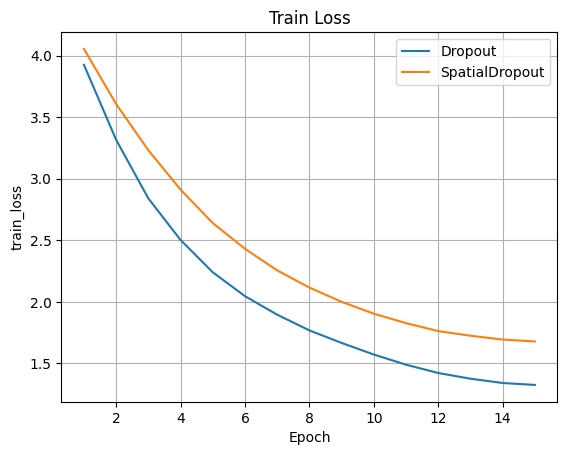

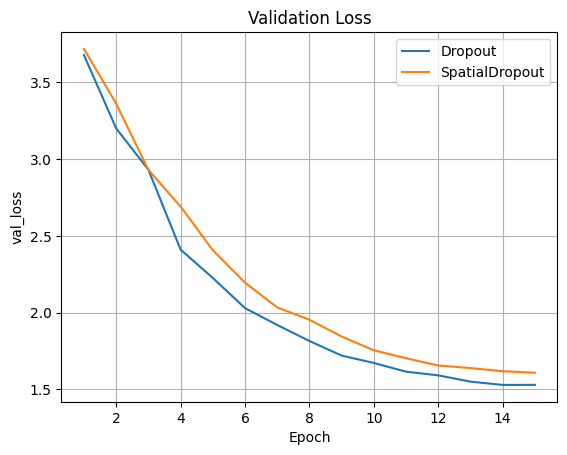

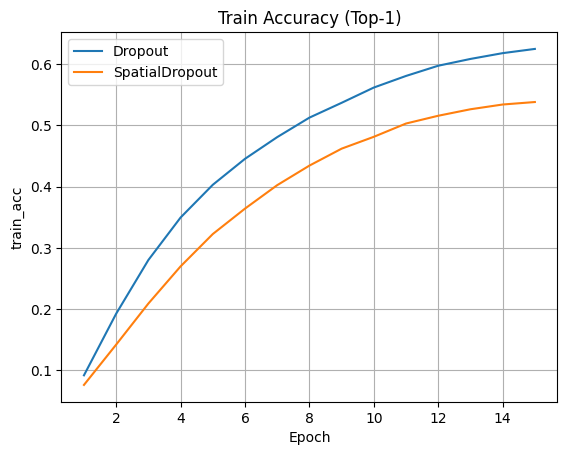

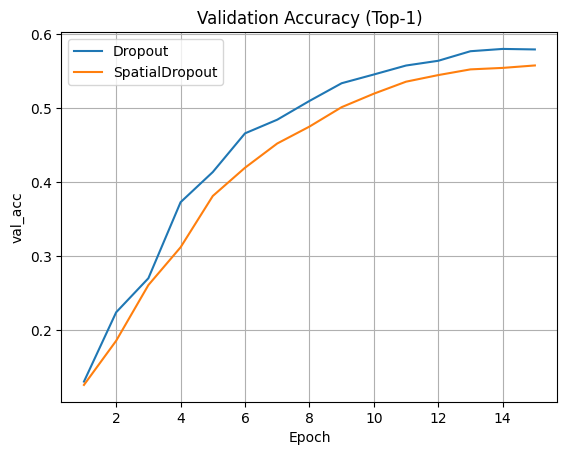

In [12]:
import matplotlib.pyplot as plt

def plot_metric(hist_a, hist_b, key, label_a="Dropout", label_b="SpatialDropout", title=None):
    epochs = [h["epoch"] for h in hist_a]
    a = [h[key] for h in hist_a]
    b = [h[key] for h in hist_b]

    plt.figure()
    plt.plot(epochs, a, label=label_a)
    plt.plot(epochs, b, label=label_b)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title if title else key)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(hist_dropout, hist_spatial, "train_loss", title="Train Loss")

plot_metric(hist_dropout, hist_spatial, "val_loss", title="Validation Loss")

plot_metric(hist_dropout, hist_spatial, "train_acc", title="Train Accuracy (Top-1)")

plot_metric(hist_dropout, hist_spatial, "val_acc", title="Validation Accuracy (Top-1)")

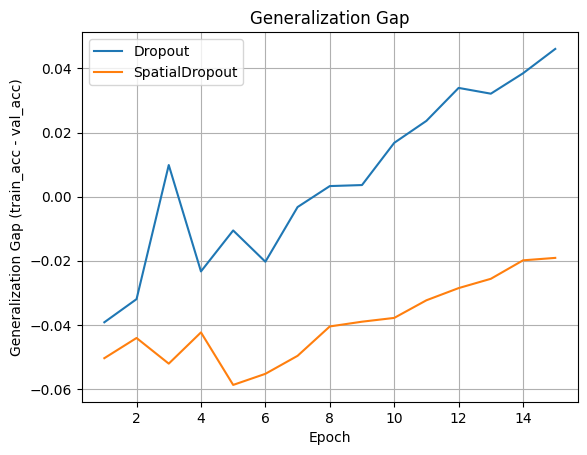

In [13]:
import matplotlib.pyplot as plt

def plot_gap(hist_a, hist_b, label_a="Dropout", label_b="SpatialDropout"):
    epochs = [h["epoch"] for h in hist_a]

    gap_a = [h["train_acc"] - h["val_acc"] for h in hist_a]
    gap_b = [h["train_acc"] - h["val_acc"] for h in hist_b]

    plt.figure()
    plt.plot(epochs, gap_a, label=label_a)
    plt.plot(epochs, gap_b, label=label_b)
    plt.xlabel("Epoch")
    plt.ylabel("Generalization Gap (train_acc - val_acc)")
    plt.title("Generalization Gap")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_gap(hist_dropout, hist_spatial)

# Dropout > Spatial Dropout çıkmasının muhtemel nedenleri (CIFAR-100 deneyi)

Senin loglarda 15. epoch sonunda:

- **Dropout**: val_acc = **0.5790**, val_loss = **1.5291**
- **Spatial Dropout**: val_acc = **0.5574**, val_loss = **1.6082**

Yani bu konfigürasyonda Spatial Dropout **underfit** etmiş gibi duruyor.

---

## 1) Spatial Dropout neden burada geride kalmış olabilir?

### (A) CIFAR-100 (32×32) + küçük model = Spatial Dropout fazla agresif
CIFAR-100 görüntüleri çok küçük. Feature map’ler erken aşamalarda zaten küçük kalıyor.
**Channel-wise dropout** (Dropout2d) kanalı komple öldürdüğü için:

- erken katmanlarda **temel kenar/tekstür kanalları** gidiyor,
- modelin “temel feature çıkarma kapasitesi” düşüyor,
- sonuç: train de val de aynı anda geride kalıyor → **underfit**.

Klasik Dropout ise element-wise olduğundan aynı kadar “kapasite kesmiyor”, daha yumuşak regularize ediyor.

---

### (B) Dropout2d çok sık uygulanıyorsa (her blokta) kapasiteyi fazla kırpar
Eğer sen modelde `Conv → BN → Act → Dropout2d`’yi:
- **stem + stage1 + stage2 + stage3** içinde sürekli kullandıysan,

bu şu anlama gelir:
> Model, her aşamada kanal sayısının bir kısmını sürekli kaybediyor.

Bu durumda Spatial Dropout, Dropout’a göre **daha büyük bir bilgi kaybı** yaratır.

---

### (C) p değeri yüksek olabilir (örn. 0.2)
`p=0.2` ile Dropout2d demek:
> her forward’da kanalların %20’si tamamen 0.

CIFAR gibi küçük görüntülerde bu fazla olabilir.

Genelde pratik:
- Spatial Dropout için **0.05–0.15** daha sağlıklı başlangıçtır.
- 0.2 üstü çoğu zaman “agresif regularization” olur.

---

### (D) Train accuracy karşılaştırması yanıltıcı olabilir
Sen `train_acc`’yi model **train modundayken** ölçüyorsun.
Train modunda:
- Dropout/Dropout2d **aktif**
- Bu yüzden train accuracy doğal olarak düşer.

Özellikle Dropout2d daha agresif olduğu için train_acc daha düşük görünür.

✅ Doğru karşılaştırma için:
- train accuracy’yi ayrıca `model.eval()` modunda ölçmek gerekir  
(“train set üzerindeki gerçek kapasite”)

---

## 2) Bu problemi nasıl düzeltiriz? (en etkili 3 hamle)

### ✅ Çözüm-1: Spatial Dropout p’yi düşür
Şunları dene:

- Dropout: `p=0.2` (aynı kalsın)
- Spatial Dropout: `p=0.05` ve `p=0.10`

Beklenti:
- Underfit azalır
- val_acc toparlar

---

### ✅ Çözüm-2: Spatial Dropout’u erken katmanlardan kaldır (sadece derin stage’lerde kullan)
En iyi pratik:
- **Stem ve Stage1**: Spatial Dropout yok
- **Stage2 ve Stage3**: Spatial Dropout var

Neden?
- Erken katmanlar “temel feature çıkarır”.
- Derin katmanlar “spesifik feature” öğrenir ve regularization’a daha uygundur.

---

### ✅ Çözüm-3: “Train accuracy”yi eval modunda da ölç (adil ölçüm)
Her epoch sonunda iki train acc raporla:

- `train_acc_trainmode` (dropout açık)
- `train_acc_evalmode` (dropout kapalı)

Beklenti:
- Spatial Dropout’un gerçek kapasitesini daha doğru görürsün.
- Underfit mi overfit mi netleşir.

---

## 3) Deney planı (en temiz ablation)

Aynı mimari, aynı optimizer, aynı epoch:

### Deney-0 (baseline)
- No dropout

### Deney-1
- Dropout p=0.2 (mevcut)

### Deney-2
- Spatial Dropout p=0.05 (sadece Stage2-3)

### Deney-3
- Spatial Dropout p=0.10 (sadece Stage2-3)

Bu şekilde Spatial Dropout’un *doğru kullanım senaryosunu* yakalarsın.

---

## 4) Beklenen yorum 
Şu anki sonuç şunu söylüyor:

> Bu mimari + bu yerleşim + bu p ile Spatial Dropout, CIFAR-100 üzerinde kapasiteyi gereğinden fazla kırpmış → underfit.

Ama doğru p + doğru yerleşimle Spatial Dropout’un tekrar rekabetçi olması çok olası.
